# 11.2.1 자료 분석

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as web
import matplotlib.pyplot as plt
%matplotlib inline

자산 : Apple, Microsoft, Samsung, Deutsche Bank, Gold ETF

In [2]:
symbols = ['AAPL', 'MSFT', '005930.KS', 'DB', 'GLD']
noa = len(symbols)

In [3]:
data = pd.DataFrame()
for sym in symbols:
    data[sym] = web.DataReader(sym, data_source = 'yahoo', end = '04/28/2019')['Close']

data.columns = symbols

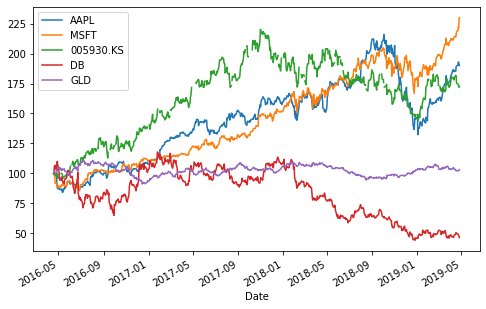

In [4]:
(data / data.loc[data.index[0]] * 100).plot(figsize = (8, 5))

초기 값을 100으로 정규화

In [5]:
rets = np.log(data / data.shift(1))

In [6]:
rets.mean() * 252 # 연율화

AAPL         0.212688
MSFT         0.275894
005930.KS    0.178589
DB          -0.255009
GLD          0.010055
dtype: float64

In [7]:
rets.cov() * 252 # 공분산 행렬

,AAPL,MSFT,005930.KS,DB,GLD
AAPL,0.056952,0.030606,0.006962,0.021442,-0.002262
MSFT,0.030606,0.048224,0.002887,0.022905,-0.002318
005930.KS,0.006962,0.002887,0.069672,0.007107,-0.000480
DB,0.021442,0.022905,0.007107,0.153041,-0.009307
GLD,-0.002262,-0.002318,-0.000480,-0.009307,0.012436


# 11.2.2 기초 이론
 - 가정
   - 투자자는 매수 포지션만 가진다. -> 가진 돈을 모두 자산 매수에 이용

In [8]:
weights = np.random.random(noa)
weights /= np.sum(weights)
weights

array([0.13129514, 0.04612702, 0.21834058, 0.29862711, 0.30561015])

포트폴리오의 수익률 기댓값
 - $\mu_p = E(∑_I w_i r_i)$
 
      $= ∑_I w_i E(r_i)$
      
      $= ∑_I w_i \mu_i$
      
      $= w^T\mu$

In [9]:
np.sum(rets.mean() * weights) * 252 # 연율화

0.006564717511736558

개별 자산 간 분산의 기댓값
 - $\sigma_{ij} = \sigma_{ji} = E[(r_i - \mu_i)(r_j - \mu_j)]$
 
 $\sigma^2_i = E[(r_i - \mu_i)^2]$
 
포트폴리오 분산의 기대값
 - $\sigma^2_p = E((r - \mu)^2)$
 
 $= ∑_{i∈I}∑_{j∈I} w_i w_j \sigma_{ij}$
 
 $= w^T ∑ w$

In [10]:
np.dot(weights.T, np.dot(rets.cov() * 252, weights)) # 분산의 기대값

0.021272597546457488

In [11]:
np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights))) # 표준편차(변동성)의 기대값

0.1458512857209613

In [12]:
prets = []
pvols = []
for p in range(2500):
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    prets.append(np.sum(rets.mean() * weights) * 252)
    pvols.append(np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights))))
    
prets = np.array(prets)
pvols = np.array(pvols)

Sharpe ratio
 - $SR = {(\mu_p - r_f) \over \sigma_p}$

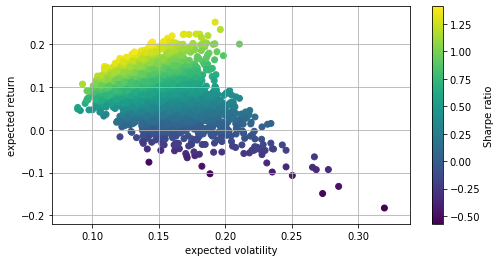

In [13]:
plt.figure(figsize = (8, 4))
plt.scatter(pvols, prets, c = prets / pvols, marker = 'o') # 단순화 위해 -> rf = 0으로 가정
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label = 'Sharpe ratio')

모든 자산 비중이 좋은 성과 X

ex) 20%의 고정된 위험 수준에 대해 비중치에 따라 다양한 수익률을 보인다.

-> 투자자 : 동일 위험 수준에 대해 최대 수익률을 가지거나 동일 수준의 수익률에 대해 최소 위험 수준을 가지는 포트폴리오 원한다.

-> 그러한 포트폴리오 집합 : 효율적 투자선(efficient frontier)

# 11.2.3 포트폴리오 최적화
 - 최적화 내용 9.2절 참고

In [14]:
def statistics(weights):
    ''' 포트폴리오 통계치 출력
    
    인수
    ====
    weights : array-like
        포트폴리오 내의 개별 자산 비중
    
    반환 값
    ======
    pret : float
        포트폴리오 수익률 기대값
    
    pvol : float
        포트폴리오 변동성 기대값
    
    pet / pvol : float
        무위험 이자율이 0일 때의 샤프 비율
    '''
    weights = np.array(weights)
    pret = np.sum(rets.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
    return np.array([pret, pvol, pret / pvol])

최적 포트폴리오 계산 : 제약 조건 하에서의 최적하 문제 -> scipy.optimize.minimize 함수 사용

In [15]:
import scipy.optimize as sco

#### 1. 샤프 비율 최대화 
 - 샤프 비율의 음수값을 최소화
 - 제약 조건 : 모든 입력 변수(주식 비중)의 합이 1

In [16]:
def min_func_sharpe(weights):
    return -statistics(weights)[2]

In [17]:
# 제약 조건
cons = ({'type' : 'eq', 'fun' : lambda x : np.sum(x) - 1})

In [18]:
# 입력값의 범위
bnds = tuple((0, 1) for x in range(noa))

In [19]:
# 주식 비중에 대한 초기값
noa * [1 / noa]

[0.2, 0.2, 0.2, 0.2, 0.2]

In [20]:
%%time
opts = sco.minimize(min_func_sharpe, noa * [1 / noa], method = 'SLSQP',
                   bounds = bnds, constraints = cons)

Wall time: 91.8 ms


In [21]:
opts

     fun: -1.4224542311935955
     jac: array([-1.41921639e-03,  6.44028187e-04, -8.10384750e-04,  2.78972280e+00,
       -2.41056085e-04])
 message: 'Optimization terminated successfully.'
    nfev: 59
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([7.14437686e-02, 5.09799638e-01, 2.23535425e-01, 7.09755348e-16,
       1.95221169e-01])

In [22]:
# 자산 비중
opts['x'].round(3)

array([0.071, 0.51 , 0.224, 0.   , 0.195])

In [23]:
statistics(opts['x']).round(3)

array([0.198, 0.139, 1.422])

수익률 기대값 : 19.8%

변동성 기대값 : 13.9%

최적 Sharp Ratio : 1.422

#### 2. 포트폴리오 분산 최소화

In [24]:
def min_func_variance(weights):
    return statistics(weights)[1] ** 2

In [25]:
# 다른 변수들 1(샤프비율 최대화)과 동일
optv = sco.minimize(min_func_variance, noa * [1 / noa], method = 'SLSQP',
                   bounds = bnds, constraints = cons)

In [26]:
optv

     fun: 0.007373865240892032
     jac: array([0.01485754, 0.01519614, 0.01452967, 0.01483422, 0.01468123])
 message: 'Optimization terminated successfully.'
    nfev: 84
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([0.06020396, 0.11811698, 0.09197555, 0.05887802, 0.67082548])

In [27]:
# 자산 비중
optv['x'].round(3)

array([0.06 , 0.118, 0.092, 0.059, 0.671])

In [28]:
statistics(optv['x']).round(3)

array([0.054, 0.086, 0.624])

수익률 기대값 : 5.4%

변동성 기대값 : 8.6%

최적 Sharp Ratio : 0.624

# 11.2.4 효율적 투자선
 - 목표 수익률을 고정 -> 최소 변동성을  가지는 포트폴리오 비중 계산
   - 목표 수익률 고정 -> 제약 조건에 추가 해야한다.

In [29]:
cons = ({'type' : 'eq', 'fun' : lambda x : statistics(x)[0] - tret},
        {'type' : 'eq', 'fun' : lambda x : np.sum(x) - 1})

bunds = tuple((0, 1) for x in weights)

In [30]:
def min_func_port(weights):
    return statistics(weights)[1]

In [31]:
%%time
trets = np.linspace(0.0, 0.25, 50)
tvols = []

for tret in trets:
    cons = ({'type' : 'eq', 'fun' : lambda x : statistics(x)[0] - tret},
        {'type' : 'eq', 'fun' : lambda x : np.sum(x) - 1})
    res = sco.minimize(min_func_port, noa * [1 / noa], method = 'SLSQP',
                      bounds = bnds, constraints = cons)
    tvols.append(res['fun'])

tvols = np.array(tvols)

Wall time: 3.92 s


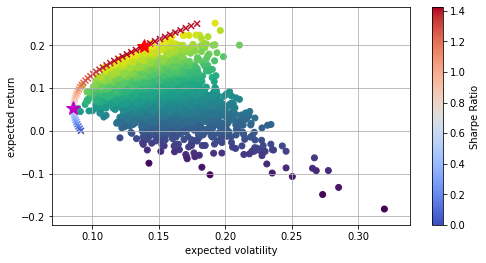

In [32]:
plt.figure(figsize = (8, 4))
plt.scatter(pvols, prets, c = prets / pvols, marker = 'o')

plt.scatter(tvols, trets, c = trets / tvols,cmap = plt.cm.coolwarm, marker = 'x')

plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0], 'r*', markersize = 15.0)

plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0], 'm*', markersize = 15.0)

plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label = 'Sharpe Ratio')

x : 특정 수익률 목표에 대한 최적 포트폴리오

o : 무작위 투자비율에 대한 포트폴리오

$\star$(red) : 최대 샤프 비율을 가지는 포트폴리오

$\star$(purple) : 최소 분산 포트폴리오

#### 효율적 투자선(Efficient Frontier) : 모든 최소 분산 포트폴리오보다 수익률이 높은 모든 최적 포트폴리오들로 구성
#### -> 특정 위험 수준에 대해 가장 높은 수익률을 가진다.

# 11.2.5 자본시장선
 - 위험 자산으로 구성된 효율적 포트폴리오 구성 -> 무위험 자산 추가 -> 전체 자산에서 무위험 자산에 투자된 비중 조정 -> 무위험 자산과 효율적 포트폴리오 사이에 직선으로 나타나는 위험-수익률 집합 중 하나 선택 -> 무위험 자산의 위험-수익률을 지나며 효율적 투자선에 접하는 접선에 포함된 포트폴리오
 - -> 효율적 투자선의 함수 형태 근사와 1차 도함수 필요 -> 큐빅 스플라인 보간법 사용(9.1.2절 참고)

In [33]:
import scipy.interpolate as sci

In [34]:
ind = np.argmin(tvols)
evols = tvols[ind:]
erets = trets[ind:]

In [35]:
ind

10

In [36]:
tvols

array([0.0914878 , 0.09047415, 0.08955459, 0.08872995, 0.08800576,
       0.08738365, 0.08686574, 0.08645371, 0.08614926, 0.08595353,
       0.08586724, 0.08589066, 0.0860237 , 0.08626586, 0.08661623,
       0.08707352, 0.08763606, 0.08830175, 0.08906858, 0.08993386,
       0.09089447, 0.09200885, 0.09334302, 0.0948877 , 0.09663282,
       0.09856775, 0.10068158, 0.10296332, 0.10540197, 0.10798659,
       0.11070764, 0.113555  , 0.11651941, 0.11959215, 0.12276509,
       0.12603067, 0.12938186, 0.13281258, 0.13631571, 0.13988686,
       0.14352104, 0.14721254, 0.15095788, 0.15475318, 0.15859473,
       0.16247926, 0.16640375, 0.17036544, 0.17436195, 0.17884191])

In [37]:
tck = sci.splrep(evols, erets)

In [38]:
def f(x):
    ''' 효율적 투자선 함수(스플라인 근사)'''
    return sci.splev(x, tck, der = 0)

def df(x):
    ''' 효율적 투자선의 1차 도함수'''
    return sci.splev(x, tck, der = 1)

자본 시장선 : $t(x) = a + b · x$
 - 조건
  - $t(x) = a + b · x$
  - $t(0) = rf ⇔ a = r_f$
  - $t(x) = f(x) ⇔ a + b · x = f(x)$
  - $t'(x) = f'(x) ⇔ b = f'(x)$

In [39]:
# 변수 p =(a, b, x)가 주어질 때
def equations(p, rf = 0.01):
    eq1 = rf - p[0]
    eq2 = rf + p[1] * p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3

scipy.optimize 라이브러리의 fsolve, equations함수에 들어갈 초기 입력 변수가 있으면 풀수 있다. -> 최적화의 성공 여부 : 초기 입력 변수 -> 시행 착오와 추측을 통해 결정

In [40]:
opt = sco.fsolve(equations, [0.01, 0.5, 0.15])
opt

array([0.01      , 1.3532631 , 0.15089436])

In [41]:
np.round(equations(opt), 6)

array([ 0., -0.,  0.])

-> 근사 잘됨

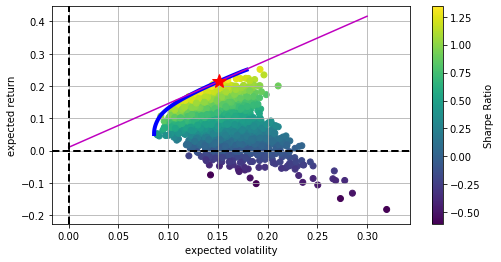

In [42]:
plt.figure(figsize = (8, 4))
plt.scatter(pvols, prets, c = (prets - 0.01) / pvols, marker = 'o')
                # 무작위 포트폴리오

plt.plot(evols, erets, 'b', lw = 4.0)
                # 효율적 투자선

cx = np.linspace(0.0, 0.3)
plt.plot(cx, opt[0] + opt[1] * cx, 'm', lw = 1.5)
                # 자본 시장선
    
plt.plot(opt[2], f(opt[2]), 'r*', markersize = 15.0) 
                # 접점

plt.grid(True)
plt.axhline(0, color = 'k', ls = '--', lw = 2.0)
plt.axvline(0, color = 'k', ls = '--', lw = 2.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label = 'Sharpe Ratio')

In [43]:
cons = ({'type' : 'eq', 'fun' : lambda x : statistics(x)[0] - f(opt[2])},
        {'type' : 'eq', 'fun' : lambda x : np.sum(x) - 1})
res = sco.minimize(min_func_port, noa * [1 / noa], method = 'SLSQP',
                  bounds = bnds, constraints = cons)

In [44]:
res['x'].round(3)

array([0.071, 0.562, 0.24 , 0.   , 0.127])

5개의 자산중 4개에 투자